## Задача банковского скоринга

### Данные:

Датасет разделен на две части: тренировочную (banking_training.csv) и тестовую (banking_test.csv). Используя banking_training.csv происходит тренировка алгоритма, предсказание осуществляется на banking_test.csv.

Описание фичей данных находится в файле banking_desc.csv


### Задача:

Бинарная вероятностная классификация.

Ваша задача спрогнозировать возниконение трудностей у кредитора в течение двух лет (переменная SeriousDlqin2yrs, принимающая значения [0,1]). Также необходимо спрогнозировать вероятность для данной переменной SeriousDlqin2yrs.

Алгоритм для выполнения задачи можно выбирать любой. Кросс-валидация должна выполняться методом KFold с n_folds=10

### Ход работы:

1. Провести первичный анализ данных: описательные статистики, распределения, наличия пропущенных значений.

2. Осуществить препроцессинг и подготовку данных: выбрать стратегию работы с пропущенными значениями (обьяснить свой выбор), осуществить генерацию дополнительных фичей (обьяснить логику). 

3. Провести корреляционный анализ и проверить выбор дополнительных фичей в сете.

4. Отобрать фичи для построения модели используя подход VarianceThreshold. Обьяснить принцип работы.

5. Отобрать фичи для построения модели используя любой из методов Univariate Feature Selection (к примеру SelectKBest или SelectPercentile). Обьяснить принцип работы.

6. Отобрать фичи для построения модели используя на выбор либо L1-регрессию (Lasso) либо подход основанный на использовании деревьев (Tree-based). Обьяснить принцип работы.

7. Протестировать на тренировочном дата сете различные наборы фичей и их работу с выбранными алгоритмами для осуществления предсказания.

8. Выбрать лучший набор фичей и лучший алгоритм для осуществленния как предсказания классов так и вероятности. Провести сравнение на тестовой выборке используя следующие метрики для оценки качества алгоритма: 

    -Классификация: Accuracy Score, f1-Score, Precision, Recall
    
    -Вероятность: log_loss Score    
    
9. Задания принимаются в виде ноутбука с полным кодом работы.

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression as log_reg
from sklearn.ensemble import RandomForestClassifier as rf, RandomForestRegressor as rf_reg
from sklearn.ensemble import GradientBoostingClassifier as gb, GradientBoostingRegressor as gb_reg

import sklearn.cluster as cluster

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

In [178]:
train = pd.read_csv ('banking_training.csv')
train.drop(columns= ['Unnamed: 0'],inplace=True)
test = pd.read_csv ('banking_test.csv')

test.drop(columns= ['Unnamed: 0'],inplace=True)

In [101]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age
0,1,0.766127,45
1,0,0.957151,40
2,0,0.658180,38
3,0,0.233810,30
4,0,0.907239,49


In [10]:
# что видим, все фичи непрерывные, два столбца с пропущенными значениями

In [8]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


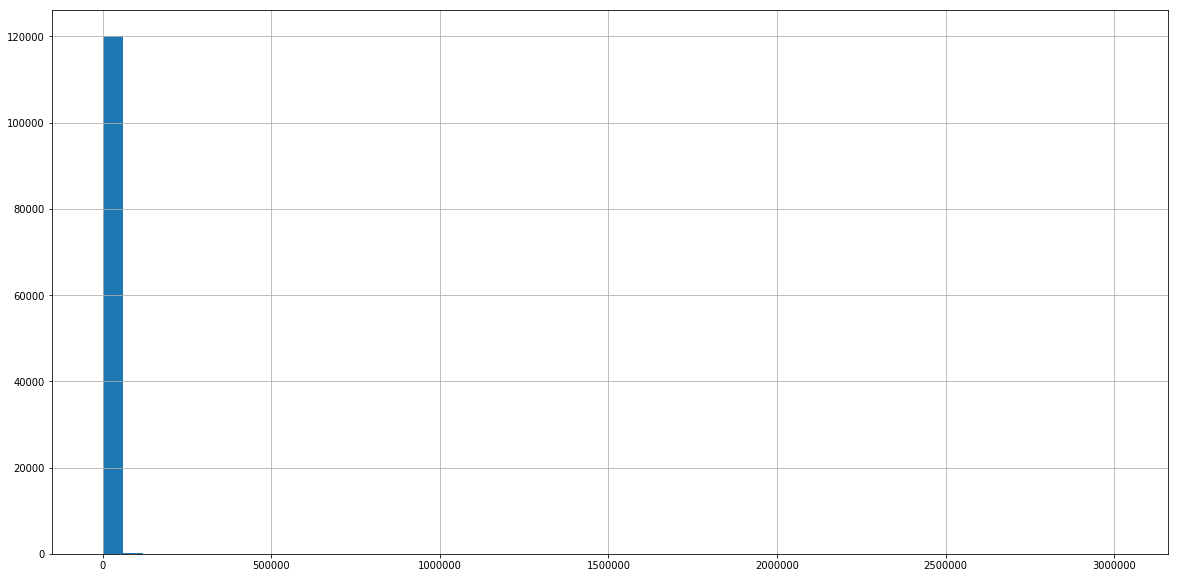

In [39]:
### посмотрим, какие значение в столбцах с нулями. У 1/5 участников значение дохода не запонленено. + очень большое стандартное отклонение
## Заполню пустые значение обучив модель и предсказв их
##train.MonthlyIncome.value_counts(dropna=False)
train.MonthlyIncome.hist(bins = 50, figsize=(20,10))
##train.MonthlyIncome[train.MonthlyIncome < 50000].hist(bins = 50, figsize=(20,10))


In [87]:
def NumberOfDependencyInputer(df):
    median = df.NumberOfDependents.median()
    df.NumberOfDependents = df[['NumberOfDependents']].fillna(value=median)

    

In [91]:
def MonthlyIncomeInputer(df):
    y = df[df.MonthlyIncome.notnull()].MonthlyIncome
    localtest = df[df['MonthlyIncome'].isnull()].drop(columns = ['MonthlyIncome'])
    localtrain = df[df.MonthlyIncome.notnull()].drop(columns = ['MonthlyIncome'])
    linreg = LinearRegression()
    linreg.fit(localtrain,y)
    predict_income = linreg.predict(localtest)
    localtrain['MonthlyIncome'] = y
    localtest['MonthlyIncome'] = predict_income
    return pd.concat([localtrain,localtest], axis = 0)
    

In [179]:
NumberOfDependencyInputer(train)


In [180]:
train = MonthlyIncomeInputer(train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D3C2D6A4E0>,
      dtype=object)

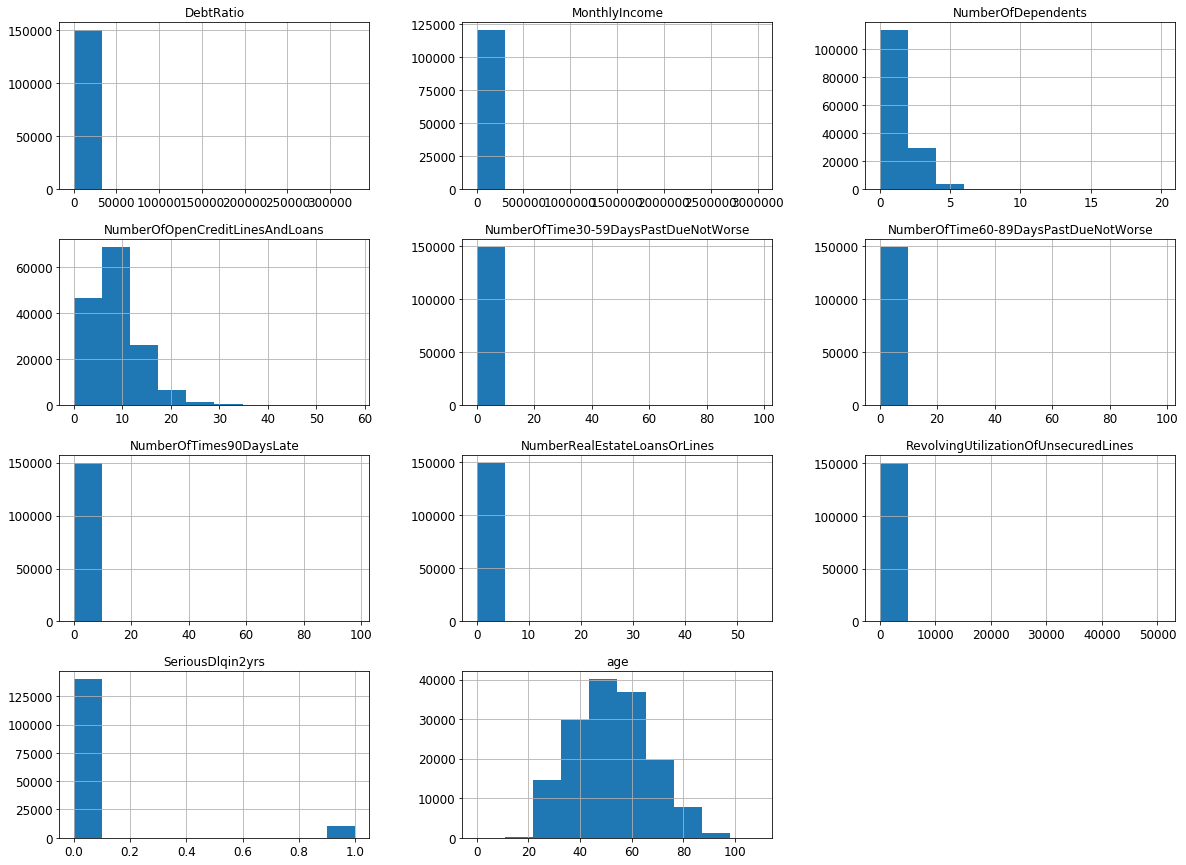

In [119]:
train.hist(figsize=(20,15))

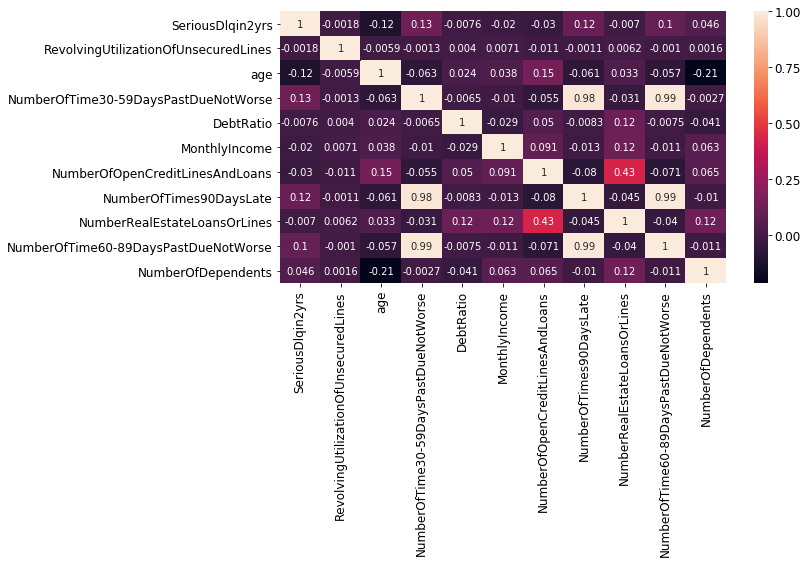

In [114]:
corr = train.corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Видим что есть зависимые переменные, попробуем сократить размерность


In [141]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [158]:
selector = VarianceThreshold()
def format_selector(selector,data, target):

    
    # Fit the model
    selector.fit(data, target)

    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
    features = [column for column in data.iloc[:,features] ]  # Gets feature names

    # Transform, Format, Return
    selector = pd.DataFrame(selector.transform(data))
    selector.columns = features
    return selector


In [159]:
variance_train = format_selector(selector,train.drop(columns=['SeriousDlqin2yrs']), train.SeriousDlqin2yrs)

In [168]:
print (train.shape)
print (variance_train.shape)
## ура, сократили на 1 фичу

(150000, 11)
(150000, 10)


In [174]:
### Попробуем лассо
rg = Lasso().fit(train.drop(columns=['SeriousDlqin2yrs']), train.SeriousDlqin2yrs)
print(rg.intercept_)
print(rg.coef_)
lasso_train = train.iloc[:,[4,10]]

0.06990991235555793
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.11603966e-06
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.31921100e-07]


In [183]:
y =  train.SeriousDlqin2yrs
X= train.drop(columns=['SeriousDlqin2yrs'])

In [215]:
def cv(X,y,clf_class):
    
    kf = StratifiedKFold(y,n_folds=10,shuffle=False)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        clf = clf_class()
        clf.fit(X_train,y_train)

        y_pred[test_index] = clf.predict(X_test)
        
    return y_pred

In [ ]:
### поробуем предсказать на исходном наборе фич

In [ ]:
X = StandardScaler().fit_transform(X)

In [191]:
print(accuracy_score(y,cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.9331533333333333
0.9008921843068148
0.8707871697811319
0.9331533333333333


In [196]:
### попробуем набор после VarianceThreshold

In [197]:

X = StandardScaler().fit_transform(variance_train)

In [195]:
print(accuracy_score(y,cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.9331533333333333
0.9008921843068148
0.8707871697811319
0.9331533333333333


In [199]:
X = StandardScaler().fit_transform(lasso_train)

In [216]:
print(accuracy_score(y,cv(X,y,log_reg)))
print(f1_score(y,cv(X,y,log_reg),average='weighted'))
print(precision_score(y,cv(X,y,log_reg),average='weighted'))
print(recall_score(y,cv(X,y,log_reg),average='weighted'))

0.9331533333333333
0.9008921843068148
0.8707871697811319
0.9331533333333333


In [201]:
### либо я что-то сделал неправильно, либо точность одинаковая, время вышло((()))